<h1> Bitcoin price forecasting using different Regression methods </h1>
This workbook is a walkthrough of how different Regression models can work to forecast Bitcoin prices.
1. Analysis Approach
2. Exploratory Data Analysis
3. Feature Creation
4. Model Creation and Training
6. Conclusion


<h2> 1. Analysis Approach </h2>
In this notebook we will look at how different regression techniques can be used to predict bitcoing prices as well as how the different techniques we will use give different results. The data we will use for this exercise is contains OHLCV Bitcoin prices between 2017-01-01 to 2020-02-01 for every 15 minutes. We will start by quickly looking at the dataset, clean if needed, feature engineering followed by building and analyzing results of the different models. We will use and compare 3 different regression techniques:
1. Linear regression
2. Linear regression with polynomial features
3. Linear regression with regularization

The objective of the analysis will be to compare the accuracy of prediction between the different techniques.

Before going into next part we start with loading some packages we will use throughout the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_notebook, show
output_notebook()
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

Loading BokehJS ...

<h2> 2. Exploratory Data Analysis </h2>
We start by importing the dataset. The dataset contains bitcoing price data (OHLC) between 2017-01-01 to 2020-02-01 with an interval of 15 minutes.

Below is a list of the columns in the data set and an explanation:
- Time - <i> Time of observed datapoint </i>
- Open - <i> Open price of the observed time interval </i>
- High - <i> Highest price of the observed time interval </i>
- Low - <i> Lowest price of the observed time interval </i>
- Close - <i> Closing price of the observed time interval </i>
- Volume - <i> Volume of transactions in BTC for the observed time interval </i>

In [2]:
df = pd.read_csv("/Users/jakobwiren/Dropbox/Coding/Bot/Binance_BTCUSDT_20170101.csv")
df['Time'] = pd.to_datetime(df['Time']) #make datetime format

In [3]:
display(df.head())

,Unnamed: 0,Time,Open,High,Low,Close,Volume
0,0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,1,2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865
2,2,2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552
3,3,2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531
4,4,2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153


Looking at the first 5 rows we see that looks fine but we can drop the first column since that is just an imported index column from Excel. Drop first column.

In [4]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [5]:
display(df.head())

,Time,Open,High,Low,Close,Volume
0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865
2,2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552
3,2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531
4,2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153


Let's look at some initial statistics at the data as well as plotting the close price over time. I am using Bokeh to plot the data in an interactive fram which enables me to zoom into different parts of the data as I wish.

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87289 entries, 0 to 87288
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    87289 non-null  datetime64[ns]
 1   Open    87289 non-null  float64       
 2   High    87289 non-null  float64       
 3   Low     87289 non-null  float64       
 4   Close   87289 non-null  float64       
 5   Volume  87289 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.0 MB


,Open,High,Low,Close,Volume
count,87289.000000,87289.000000,87289.000000,87289.000000,87289.000000
mean,7536.241756,7560.807045,7510.383124,7536.268695,364.013618
std,2816.681197,2834.480469,2797.316850,2816.622884,436.838805
min,2830.000000,2880.010000,2817.000000,2820.000000,0.000000
25%,5624.980000,5639.990000,5610.000000,5624.980000,142.351631
50%,7327.480000,7344.950000,7311.000000,7326.900000,256.692541
75%,9208.330000,9231.350000,9180.060000,9209.110000,435.298532
max,19756.000000,19798.680000,19680.200000,19756.020000,10340.338241


In [37]:
f = figure(width=900, height=400, x_axis_type='datetime', x_axis_label = 'Time', y_axis_label = 'Close Price (USD)')
f.line(df['Time'], df['Close'], line_width=2)
show(f)

Looking at the dataset we can see that each column has the same count and no strange deviations in the std, mean, min or max values. The volume column is obviously holding different values compared to the other columns due to the scale of the feature. This will be addressed later on in the workbook, but the conclusion from the first analysis is that the quality of the data is sufficiently good without any missing values or extreme values we need to address before carrying on.

We can see from the chart the Bitcoin had its high at almost 20,000 USD in Dec 2019 and later dropped to below 5,000 to stabalize around 10,000 in the end of 2019. As a first step, let's look at the autocorrelation plot which indicates if correlation exists with previous values. In this case, my hypothesis is that there should be high autocorrelation since previous prices affect the next price.

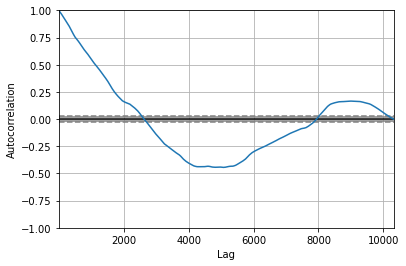

In [36]:
pd.plotting.autocorrelation_plot(df['Close']) 

When plotting the autocorrelation we can see extremely high autocorrelation which makes sense since the next price will always be very very similiar to the previous one, the previous one before that and so on. We can therefore accept the hypothesis.

To further support the exploratory analysis we generate a pairplot to review potential correlations as well as the distribution for each feature.

In [9]:

sns.pairplot(df);

By looking at the pairplot we can see that the price features visualize as a diagonal line, indicating strong correlations. This of course makes sense since opening, close, high and lowest price are highly very similiar to each other. We can also confirm that we have no significant outliers.

The dataset is good to contine being prepared for generating predictive models.

<h2> 3. Feature Creation </h2>

In order to generate a predictive model I create some new features from the data we have for a better chance of a better prediction.

In [10]:
def preprocess_data(df):
    #make datetime
    df['Time'] = pd.to_datetime(df['Time'], unit ='s')
    
    #create features for dates
    df['Month'] = pd.DatetimeIndex(df['Time']).month
    df['Year'] = pd.DatetimeIndex(df['Time']).year
    df['Day'] = pd.DatetimeIndex(df['Time']).day
    df['Hour'] = pd.DatetimeIndex(df['Time']).hour
    df['Weekend'] = [1 if x >=5 else 0 for x in df['Day']]
    df.head()

    #lag k
    df['lag k = -1'] = df['Close'].shift(1)
    df['lag k = -2'] = df['Close'].shift(2)
    df['lag k = -3'] = df['Close'].shift(3)
    #lag volume
    df['vol lag k = -1'] = df['Volume'].shift(1)
    df['vol lag k = -2'] = df['Volume'].shift(2)
    df['vol lag k = -3'] = df['Volume'].shift(3)
    #lag Low
    df['low lag k = -1'] = df['Low'].shift(1)
    df['low lag k = -2'] = df['Low'].shift(2)
    df['low lag k = -3'] = df['Low'].shift(3)
    #lag High
    df['high lag k = -1'] = df['High'].shift(1)
    df['high lag k = -2'] = df['High'].shift(2)
    df['high lag k = -3'] = df['High'].shift(3)
    #lag Open
    df['open lag k = -1'] = df['Open'].shift(1)
    df['open lag k = -2'] = df['Open'].shift(2)
    df['open lag k = -3'] = df['Open'].shift(3)
    #df['rsi'] = computeRSI(df['Close'], 12)
    df.head()
    #remove 10 rows
    df = df.iloc[3:]
    return df

In [29]:
df = preprocess_data(df)
df = df[df['Time'] > '2019-07-01']
df.head()

,Time,Open,High,Low,Close,Volume,Month,Year,Day,Hour,...,vol lag k = -3,low lag k = -1,low lag k = -2,low lag k = -3,high lag k = -1,high lag k = -2,high lag k = -3,open lag k = -1,open lag k = -2,open lag k = -3
76974,2019-11-01 01:45:00,9113.59,9113.99,9090.08,9092.65,257.274274,11,2019,1,1,...,172.847246,9104.05,9110.63,9120.96,9123.91,9133.00,9141.70,9117.10,9133.00,9127.00
76975,2019-11-01 02:00:00,9092.71,9110.56,9080.51,9083.38,201.538313,11,2019,1,2,...,162.942946,9090.08,9104.05,9110.63,9113.99,9123.91,9133.00,9113.59,9117.10,9133.00
76976,2019-11-01 02:15:00,9082.34,9106.00,9067.14,9086.70,429.976364,11,2019,1,2,...,399.569658,9080.51,9090.08,9104.05,9110.56,9113.99,9123.91,9092.71,9113.59,9117.10
76977,2019-11-01 02:30:00,9085.90,9090.55,9069.00,9080.87,205.880235,11,2019,1,2,...,257.274274,9067.14,9080.51,9090.08,9106.00,9110.56,9113.99,9082.34,9092.71,9113.59
76978,2019-11-01 02:45:00,9080.83,9140.61,9062.09,9123.16,542.560180,11,2019,1,2,...,201.538313,9069.00,9067.14,9080.51,9090.55,9106.00,9110.56,9085.90,9082.34,9092.71


<h2> 4. Model Creation and Training </h2>
As mentioned we will create 3 models to compare with:
1. Linear Regression
2. Linear Regression with polynomial features
3. Linear Regression with regularization

Let's split the data into train and test. But before we do that I also normalize the data in the training set to cater for the different scales between the features. I don't shuffle the input as we are looking at time series and need to keep the order. As we saw previously there is a high autocorrelation in the dataset.

In [30]:
X = df[['Month', 'Year',
       'Day', 'Hour', 'Weekend', 'lag k = -1', 'lag k = -2',
       'vol lag k = -1', 'vol lag k = -2', 'low lag k = -1',
       'low lag k = -2', 'high lag k = -1',
       'high lag k = -2', 'open lag k = -1',
       'open lag k = -2']]
y = df['Close']

#normalize data in order to prevent scaling faults for different features
X_normalized = pd.DataFrame(preprocessing.normalize(X))

X_train, X_test, y_train, y_test = train_test_split(
     X_normalized, y, test_size=0.3, shuffle = False)

In [31]:
print('Shape for training set: ',X_train.shape)
print('Shape for test set: ', X_test.shape)

X_train.describe()


Shape for training set:  (7220, 15)
Shape for test set:  (3095, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000,7220.000000
mean,0.000434,0.091951,0.000660,0.000523,0.000038,0.351614,0.351615,0.023214,0.023215,0.350919,0.350921,0.352288,0.352290,0.351615,0.351618
std,0.000199,0.008053,0.000427,0.000319,0.000017,0.001586,0.001435,0.025928,0.025932,0.001910,0.001896,0.001199,0.001134,0.001435,0.001620
min,0.000039,0.074071,0.000038,0.000000,0.000000,0.325059,0.327524,0.002004,0.002003,0.319489,0.311397,0.328046,0.328298,0.327524,0.311685
25%,0.000420,0.084288,0.000287,0.000245,0.000040,0.351469,0.351574,0.009822,0.009819,0.350864,0.350849,0.352087,0.352091,0.351572,0.351447
50%,0.000513,0.095268,0.000569,0.000524,0.000046,0.351885,0.351862,0.015235,0.015225,0.351383,0.351360,0.352389,0.352397,0.351862,0.351885
75%,0.000578,0.098322,0.001035,0.000788,0.000049,0.352262,0.352169,0.025294,0.025317,0.351694,0.351684,0.352715,0.352730,0.352166,0.352272
max,0.000639,0.107682,0.001522,0.001224,0.000053,0.355376,0.353382,0.325328,0.327466,0.352530,0.352695,0.356496,0.356192,0.353382,0.355082


We can now see that the features have been normalized. Let's now create our three models.

<h3> Linear Regression </h3>

In [32]:
lin_reg = LinearRegression().fit(X_train, y_train)

<h3> Linear Regression with polynomial features

In [33]:
#create polynomial features
degree = 2
pf = PolynomialFeatures(degree)
X_N_PF = pf.fit_transform(X_normalized)

X_train_pf, X_test_pf, y_train_pf, y_test_pf = train_test_split(
     X_N_PF, y, test_size=0.3, shuffle = False)

lin_reg_pf = LinearRegression().fit(X_train_pf, y_train_pf)

<h3> Linear Regression with Lasso Regularization 

In [34]:
lasso = Lasso().fit(X_train, y_train)

#X_train_L, X_test_L, y_train_L, y_test_L = train_test_split(
#     X_N_L, y, test_size=0.3, shuffle = False)

#lin_reg_L = LinearRegression().fit(X_train_L, y_train_L)

RMSE Linear Regression: 237.434407
RMSE Linear Regression with PF: 51.344528
RMSE Linear Regression with Lasso: 443.196209


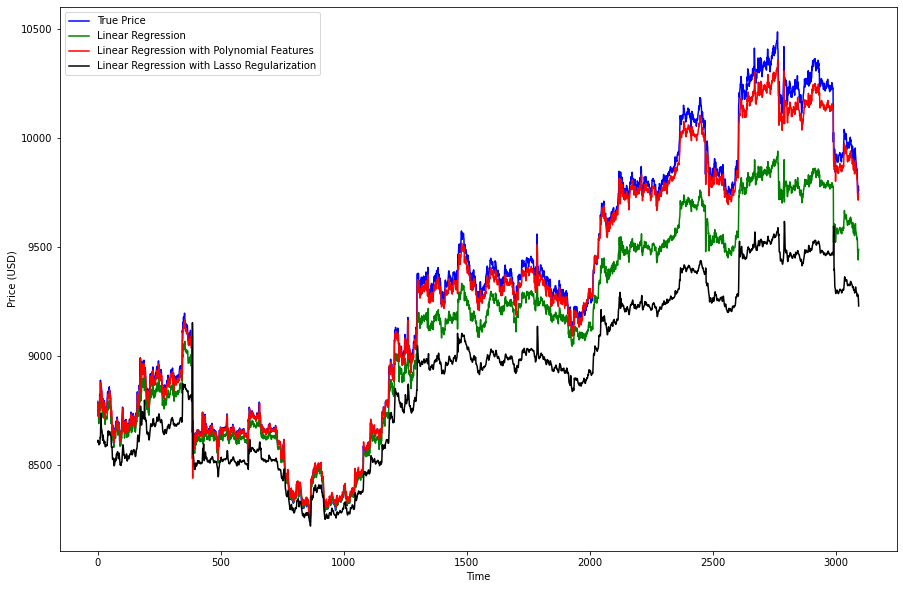

In [35]:
lin_reg_pred = lin_reg.predict(X_test)
lin_reg_pf_pred = lin_reg_pf.predict(X_test_pf)
lin_reg_L_pred = lasso.predict(X_test)


print("RMSE Linear Regression: %f" % (np.sqrt(mean_squared_error(y_test, lin_reg_pred))))
print("RMSE Linear Regression with PF: %f" % (np.sqrt(mean_squared_error(y_test, lin_reg_pf_pred))))
print("RMSE Linear Regression with Lasso: %f" % (np.sqrt(mean_squared_error(y_test, lin_reg_L_pred))))

fig= plt.figure(figsize=(15,10))
plt.plot(np.arange(0,len(y_test)), y_test, color = 'blue', label = 'True Price')
plt.plot(np.arange(0,len(y_test)), lin_reg_pred, color = 'green', label = 'Linear Regression')
plt.plot(np.arange(0,len(y_test)), lin_reg_pf_pred, color = 'red', label = 'Linear Regression with Polynomial Features')
plt.plot(np.arange(0,len(y_test)), lin_reg_L_pred, color = 'black', label = 'Linear Regression with Lasso Regularization')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()

<h1> 5. Conclusion </h1> 
As we can see in the chart, the model using polynomial features with 2 degrees perform best after linear regression followed by Lasso regularization. Looking at the charts visually it seems like the linear regression and Lasso are skewed, suggesting this could be improved by further analysis.

As next steps, I believe working more on the hyperparemeters and trying more methods could improve the results of the prediction.